# MCT4052 Workshop 8b: Tensorflow-Keras ANN Regressor

*Author: Stefano Fasciani, stefano.fasciani@imv.uio.no, Department of Musicology, University of Oslo.*

This notebook shows how to train, test and use an ANN for regression in tensorflow. We use the same dataset used in earlier Workshops.

### 1. Importing Tensorflow and Keras


In [1]:
import numpy as np
import pandas as pd
import librosa, librosa.display
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
import IPython.display as Ipd
import os
import sklearn
import scipy
import datetime

%matplotlib inline
%config IPCompleter.greedy=True

# Import TensorFlow and Keras
import tensorflow as tf

# display tensorflow version (this notwbook was developed with 2.7)
print(tf.__version__)

2.7.0


### 2. Computing features, targets and splitting the dataset

This time we store the features in an numpy array of matrices (i.e. a 3D array) ad tensorflow is able to "flatten" the data internally (is instructed to do so).

In [2]:
sr = 44100

def lin_interp_2d(data, out_size):
    
    x_in_size = data.shape[1]
    y_in_size = data.shape[0]
    x_in = np.arange(0,x_in_size)
    y_in = np.arange(0,y_in_size)
    interpolator = scipy.interpolate.interp2d(x_in, y_in, data, kind='linear')
    x_out = np.arange(0,x_in_size-1,((x_in_size-1)/out_size[1]))
    y_out = np.arange(0,y_in_size-1,((y_in_size-1)/out_size[0]))
    output = interpolator(x_out, y_out)
    output = output[0:out_size[0],0:out_size[1]]
    
    return output

def extract_features_targets(filename, sr):
    
    signal, dummy = librosa.load(filename, sr, mono=True)
    
    features = librosa.feature.melspectrogram(signal, n_mels=32)
    
    features = lin_interp_2d(features, (32,16)) # scaling to identical lenght
    
    targets = np.zeros((1,2))
    #centroid and flatness are in very sifferent ranges, they are scaled to be in a similar range (important for the loss)
    targets[0,0] = np.mean(librosa.feature.spectral_centroid(signal))/1000 #scaling the centroid to smaller range
    targets[0,1] = np.mean(librosa.feature.spectral_flatness(signal))*100 #scaling the flatness to larger range
    
    return features, targets

filenames = os.listdir('./data/examples2')
features = np.zeros((len(filenames),32,16)) #3D Numpy array to store MFCC computed e changed if using more or less features)
targets = np.zeros((len(filenames),2))

for i in range(len(filenames)):
    features[i,:,:], targets[i,:] = extract_features_targets('./data/examples2/'+filenames[i], sr) # alternative features[i,:,:]


print('Done!')

Done!


In [3]:
# for the splitting we still use scikit learn

from sklearn.model_selection import train_test_split

#splitting the dataset in training and testing parts
feat_train, feat_test, tar_train, tar_test = train_test_split(features, targets, test_size=0.2)

### 3. Defining, compiling, training and using the ANN

Compared to the previous notebook, setting an appropriate loss function (related to the error) is a key element to train a regression model

In [4]:
# building the model, the input layer must match the input data
# for regression we need an output for each target value
# here we also integrate a normalization layer (not an absolute must)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 16)),
    tf.keras.layers.Normalization(),
    tf.keras.layers.Dense(10, activation='tanh'),
    tf.keras.layers.Dense(2, activation='relu')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 512)               0         
                                                                 
 normalization (Normalizatio  (None, 512)              1025      
 n)                                                              
                                                                 
 dense (Dense)               (None, 10)                5130      
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 6,177
Trainable params: 5,152
Non-trainable params: 1,025
_________________________________________________________________


2022-03-22 17:00:25.544745: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# setting loss function and metric
# we also specify the learning rate, which needs to be further
# adjusted to speed up the training

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mean_absolute_error')

In [6]:
# fitting the model and setting some parameters

history = model.fit(
    feat_train,
    tar_train,
    batch_size=32,
    epochs=500,
    validation_split = 0.1
)

Epoch 1/500
4/4 [==============================] - 0s 43ms/step - loss: 9.6941 - val_loss: 8.4760
Epoch 2/500
4/4 [==============================] - 0s 6ms/step - loss: 9.5499 - val_loss: 8.3930
Epoch 3/500
4/4 [==============================] - 0s 7ms/step - loss: 9.4517 - val_loss: 8.1574
Epoch 4/500
4/4 [==============================] - 0s 7ms/step - loss: 9.4021 - val_loss: 8.2144
Epoch 5/500
4/4 [==============================] - 0s 6ms/step - loss: 9.3649 - val_loss: 8.1164
Epoch 6/500
4/4 [==============================] - 0s 7ms/step - loss: 9.3288 - val_loss: 8.0370
Epoch 7/500
4/4 [==============================] - 0s 7ms/step - loss: 9.2850 - val_loss: 7.9961
Epoch 8/500
4/4 [==============================] - 0s 8ms/step - loss: 9.2308 - val_loss: 7.9797
Epoch 9/500
4/4 [==============================] - 0s 7ms/step - loss: 9.2120 - val_loss: 7.9089
Epoch 10/500
4/4 [==============================] - 0s 7ms/step - loss: 9.1982 - val_loss: 7.8723
Epoch 11/500
4/4 [==========

4/4 [==============================] - 0s 7ms/step - loss: 6.5120 - val_loss: 6.9994
Epoch 85/500
4/4 [==============================] - 0s 6ms/step - loss: 6.7161 - val_loss: 7.0485
Epoch 86/500
4/4 [==============================] - 0s 6ms/step - loss: 6.6737 - val_loss: 6.9890
Epoch 87/500
4/4 [==============================] - 0s 6ms/step - loss: 6.5422 - val_loss: 6.7870
Epoch 88/500
4/4 [==============================] - 0s 6ms/step - loss: 6.1722 - val_loss: 6.5249
Epoch 89/500
4/4 [==============================] - 0s 7ms/step - loss: 6.0782 - val_loss: 6.3417
Epoch 90/500
4/4 [==============================] - 0s 7ms/step - loss: 6.0814 - val_loss: 6.1369
Epoch 91/500
4/4 [==============================] - 0s 6ms/step - loss: 6.0400 - val_loss: 6.1153
Epoch 92/500
4/4 [==============================] - 0s 6ms/step - loss: 5.9752 - val_loss: 6.1570
Epoch 93/500
4/4 [==============================] - 0s 7ms/step - loss: 6.0397 - val_loss: 5.8566
Epoch 94/500
4/4 [===============

4/4 [==============================] - 0s 7ms/step - loss: 3.5601 - val_loss: 5.1552
Epoch 168/500
4/4 [==============================] - 0s 6ms/step - loss: 3.5695 - val_loss: 5.1389
Epoch 169/500
4/4 [==============================] - 0s 6ms/step - loss: 3.5483 - val_loss: 5.1337
Epoch 170/500
4/4 [==============================] - 0s 7ms/step - loss: 3.5345 - val_loss: 5.2868
Epoch 171/500
4/4 [==============================] - 0s 7ms/step - loss: 3.5070 - val_loss: 5.2818
Epoch 172/500
4/4 [==============================] - 0s 7ms/step - loss: 3.4833 - val_loss: 5.2955
Epoch 173/500
4/4 [==============================] - 0s 7ms/step - loss: 3.5077 - val_loss: 5.2970
Epoch 174/500
4/4 [==============================] - 0s 6ms/step - loss: 3.4774 - val_loss: 5.2766
Epoch 175/500
4/4 [==============================] - 0s 7ms/step - loss: 3.4646 - val_loss: 5.2708
Epoch 176/500
4/4 [==============================] - 0s 8ms/step - loss: 3.4541 - val_loss: 5.2841
Epoch 177/500
4/4 [=====

Epoch 250/500
4/4 [==============================] - 0s 7ms/step - loss: 3.3080 - val_loss: 4.6407
Epoch 251/500
4/4 [==============================] - 0s 6ms/step - loss: 3.2648 - val_loss: 4.6571
Epoch 252/500
4/4 [==============================] - 0s 7ms/step - loss: 3.2653 - val_loss: 4.6325
Epoch 253/500
4/4 [==============================] - 0s 7ms/step - loss: 3.2483 - val_loss: 4.6208
Epoch 254/500
4/4 [==============================] - 0s 7ms/step - loss: 3.2359 - val_loss: 4.6503
Epoch 255/500
4/4 [==============================] - 0s 6ms/step - loss: 3.2330 - val_loss: 4.6385
Epoch 256/500
4/4 [==============================] - 0s 7ms/step - loss: 3.2362 - val_loss: 4.6232
Epoch 257/500
4/4 [==============================] - 0s 7ms/step - loss: 3.2464 - val_loss: 4.6583
Epoch 258/500
4/4 [==============================] - 0s 8ms/step - loss: 3.2350 - val_loss: 4.6852
Epoch 259/500
4/4 [==============================] - 0s 7ms/step - loss: 3.2363 - val_loss: 4.6899
Epoch 260/

4/4 [==============================] - 0s 7ms/step - loss: 3.2000 - val_loss: 4.6041
Epoch 333/500
4/4 [==============================] - 0s 7ms/step - loss: 3.1994 - val_loss: 4.5872
Epoch 334/500
4/4 [==============================] - 0s 7ms/step - loss: 3.1997 - val_loss: 4.5891
Epoch 335/500
4/4 [==============================] - 0s 7ms/step - loss: 3.1965 - val_loss: 4.5904
Epoch 336/500
4/4 [==============================] - 0s 6ms/step - loss: 3.1996 - val_loss: 4.5989
Epoch 337/500
4/4 [==============================] - 0s 6ms/step - loss: 3.2025 - val_loss: 4.5946
Epoch 338/500
4/4 [==============================] - 0s 6ms/step - loss: 3.2006 - val_loss: 4.6015
Epoch 339/500
4/4 [==============================] - 0s 7ms/step - loss: 3.2039 - val_loss: 4.5771
Epoch 340/500
4/4 [==============================] - 0s 6ms/step - loss: 3.2015 - val_loss: 4.5922
Epoch 341/500
4/4 [==============================] - 0s 7ms/step - loss: 3.2024 - val_loss: 4.5855
Epoch 342/500
4/4 [=====

Epoch 415/500
4/4 [==============================] - 0s 7ms/step - loss: 3.2027 - val_loss: 4.5500
Epoch 416/500
4/4 [==============================] - 0s 8ms/step - loss: 3.1972 - val_loss: 4.5704
Epoch 417/500
4/4 [==============================] - 0s 7ms/step - loss: 3.1982 - val_loss: 4.5445
Epoch 418/500
4/4 [==============================] - 0s 6ms/step - loss: 3.1995 - val_loss: 4.5455
Epoch 419/500
4/4 [==============================] - 0s 7ms/step - loss: 3.1977 - val_loss: 4.5432
Epoch 420/500
4/4 [==============================] - 0s 7ms/step - loss: 3.1986 - val_loss: 4.5122
Epoch 421/500
4/4 [==============================] - 0s 7ms/step - loss: 3.2117 - val_loss: 4.5062
Epoch 422/500
4/4 [==============================] - 0s 7ms/step - loss: 3.2048 - val_loss: 4.4997
Epoch 423/500
4/4 [==============================] - 0s 7ms/step - loss: 3.1981 - val_loss: 4.4973
Epoch 424/500
4/4 [==============================] - 0s 6ms/step - loss: 3.1988 - val_loss: 4.5226
Epoch 425/

4/4 [==============================] - 0s 7ms/step - loss: 3.1848 - val_loss: 4.4212
Epoch 498/500
4/4 [==============================] - 0s 7ms/step - loss: 3.1861 - val_loss: 4.4246
Epoch 499/500
4/4 [==============================] - 0s 6ms/step - loss: 3.1907 - val_loss: 4.4360
Epoch 500/500
4/4 [==============================] - 0s 6ms/step - loss: 3.1872 - val_loss: 4.4355


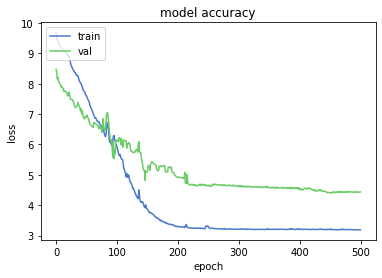

In [7]:
# plotting validation and train loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
# evaluating performance on test set
# tensorflow provides many error-related metrics
# but it does not provide the R2 score (but we can still use scikit learn)

tar_pred = model.predict(feat_test)

print('Coefficient of determination (r2 score): %.4f'% sklearn.metrics.r2_score(tar_test, tar_pred))

Coefficient of determination (r2 score): 0.4717


### 4. Follow up activities

1. Try to improve performances.